In [1]:
import os
import sys
import glob
import torch
import platform

import os.path as op
import numpy as np
from matplotlib import pyplot as plt

sys.path.append('..')
from scripts.data import DataInterface
from scripts.model import ModelInteface
from scripts.utils import ntore_to_redgreen, gen_tore_plus, ToreSeqReader

%load_ext autoreload
%autoreload 2

In [2]:
print('Current Directory: ', os.getcwd())
print('Current Node: ', platform.node())
print('Cuda availability: ', torch.cuda.is_available())

Current Directory:  /mnt/nfs/scratch1/zhongyangzha/DVS_HPE/U2NetTORE/notebooks
Current Node:  node184
Cuda availability:  True


In [3]:
def get_model_path(date, root='/mnt/nfs/scratch1/zhongyangzha/DVS_HPE/U2NetTORE/lightning_logs', best=True):
    model_subdir = op.join(root, date, 'checkpoints')
    if best:
        model_path = glob.glob(op.join(model_subdir, 'best*'))[0]
    else:
        model_path = op.join(model_subdir, 'last.ckpt')
    return model_path

In [4]:
data = DataInterface(num_workers=1, dataset='mask_dataset', batch_size=1, 
                     tore_dir="/mnt/nfs/scratch1/zhongyangzha/DVS_HPE/ntore_dataset/synthetic", 
                     mask_dir='/mnt/nfs/work1/trahman/zhongyangzha/dvs_hpe/ntore_dataset/masks_acc', 
                     seq_len=16, acc_time=0.02, step_size=0.02, percentile=90,
                     cache_size=1, base_number=128, test_characters=['Diluc','Xiangling'], 
                     accumulated=True, cycle_views=False, ori_tore=True)
# Initiate train/val/test set and loaders
data.setup()

MaskDataset
From Data interface: 1
running dataset setup...
[√] Using pre-accumulated mask files.
===== READER NUM: 1188 =======
Train and Val indexes shape:  (3411466, 2)
===== READER NUM: 264 =======
Test indexes shape:  (758073, 2)
Length of train data: 2729184 
Length of val data:  682282
[x] Using Original TORE Volume.
[x] Using Original TORE Volume.
[x] Using Original TORE Volume.


In [5]:
device = 'cuda'

# No ConvLSTM
model_path = get_model_path('05-10-19-09-40')
# ConvLSTM used
# model_path = get_model_path('04-05-18-25')

model = ModelInteface.load_from_checkpoint(model_path)
model = model.to(device)
print('ConvLSTM used: ', model.model.use_convlstm)

Model hparams saved!
Output channel number: 16
ConvLSTM used:  False


In [7]:
# Using data from loader
idx = 290
batch = data.testset[idx]
ntores, masks = batch
# ntores = ntores.to('cuda')
res = model.predict_step(torch.tensor(batch[0]).float().unsqueeze(0).to(device), idx)
del batch

/tmp/ipykernel_144785/3733996120.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  res = model.predict_step(torch.tensor(batch[0]).float().unsqueeze(0).to(device), idx)


In [38]:
# Using data from folder directly
idx = 159
meta_file_path = r'/mnt/nfs/work1/trahman/zhongyangzha/dvs_hpe/ntore_dataset/ddhp22/S08_DBHL_T0002/meta.json'
reader = ToreSeqReader(meta_file_path=meta_file_path)
tores = torch.tensor(reader.get_tore_by_index(idx)).float().unsqueeze(0)
# tores = torch.zeros(16, 6, 260, 346).float()
# for i in range(16):
#     tores[i] = torch.tensor(reader.get_tore_by_index(idx+i)).float()
#     ntore = torch.tensor(gen_tore_plus(tore, percentile=90)).float()
masks, scores = model.predict_step(tores.to(device), 10)

In [39]:
ntore_to_redgreen(tores.squeeze().cpu().detach().numpy()).shape

(3, 3, 260, 346)

(-0.5, 345.5, 259.5, -0.5)

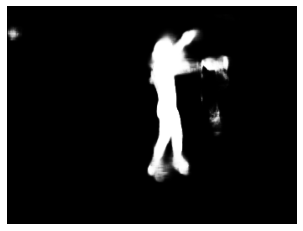

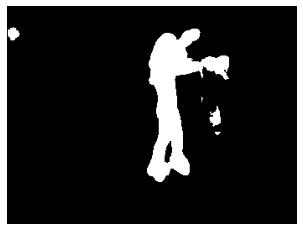

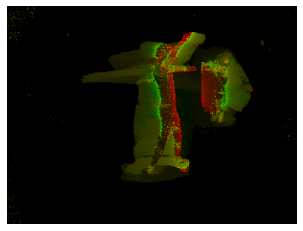

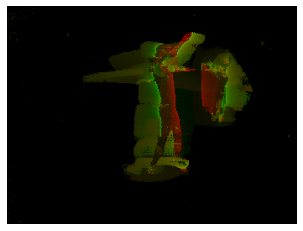

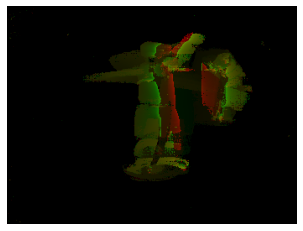

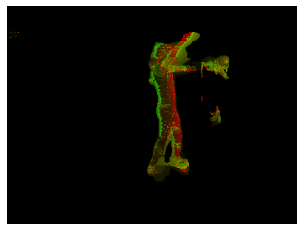

In [40]:
inbatch_idx = 0

mask_binary = np.where(masks[inbatch_idx].cpu().detach().numpy()>0.1,1,0)
combined_ntore = ntore_to_redgreen(tores.squeeze().cpu().detach().numpy()).transpose(0,2,3,1)
# res_binary = np.where(res.numpy()>0.1,1,0)[idx]
plt.figure()
plt.imshow(torch.sigmoid(masks[inbatch_idx]).cpu().detach().numpy(), cmap='gray')
plt.axis('off')
plt.figure()
plt.imshow(mask_binary, cmap='gray')
plt.axis('off')
# plt.figure()
# plt.imshow(masks[inbatch_idx])
# plt.axis('off')
plt.figure()
plt.imshow(combined_ntore[0])
plt.axis('off')
plt.figure()
plt.imshow(combined_ntore[1])
plt.axis('off')
plt.figure()
plt.imshow(combined_ntore[2])
plt.axis('off')
plt.figure()
plt.imshow(combined_ntore[0]*mask_binary[...,np.newaxis])
plt.axis('off')
# plt.imshow(ntores[inbatch_idx][0].cpu().detach().numpy())
# plt.figure()
# plt.imshow(ntores[inbatch_idx][4].cpu().detach().numpy())
# plt.figure()
# plt.imshow(ntores[inbatch_idx][1].cpu().detach().numpy())
# plt.figure()
# plt.imshow(ntores[inbatch_idx][5].cpu().detach().numpy())




In [11]:
combined_ntore.shape

(3, 260, 346, 3)